# pytorch 60 min blitz tutorial

http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

## neural nets

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [3]:
net = Net()
print(net)

Net(
  (conv1): Conv2d (1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)


In [4]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


The input to the forward is an autograd.Variable, and so is the output. Note: Expected input size to this net(LeNet) is 32x32. To use this net on MNIST dataset,please resize the images from the dataset to 32x32.

In [5]:
input = Variable(torch.randn(1, 1, 32, 32))
out = net(input)
print(out)

Variable containing:
 0.0872  0.0166  0.0343  0.0204 -0.0455  0.0600 -0.0646  0.1547  0.1398 -0.1308
[torch.FloatTensor of size 1x10]



Zero the gradient buffers of all parameters and backprops with random gradients:


In [6]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### loss function

There are several different loss functions under the nn package . A simple loss is: nn.MSELoss which computes the mean-squared error between the input and the target.

In [7]:
output = net(input)
target = Variable(torch.arange(1, 11))  # a dummy target, for example
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

Variable containing:
 38.2735
[torch.FloatTensor of size 1]



So, when we call loss.backward(), the whole graph is differentiated w.r.t. the loss, and all Variables in the graph will have their .grad Variable accumulated with the gradient.

For illustration, let us follow a few steps backward:

In [9]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

### backprop

To backpropagate the error all we have to do is to `loss.backward()`. You need to clear the existing gradients though, else gradients will be accumulated to existing gradients

In [10]:
net.zero_grad()  # zeroes the gradient buffers of all parameters

In [11]:
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
Variable containing:
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 6]



In [12]:
loss.backward()

In [13]:
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad after backward
Variable containing:
-0.0527
 0.0775
-0.0778
-0.0466
-0.0580
-0.1278
[torch.FloatTensor of size 6]



### update the weights

In [14]:
# weight = weight - learning_rate * gradient

In [15]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

torch has `optim` to allow different update methods

In [16]:
import torch.optim as optim

In [20]:
# create optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()  # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()  # Does the update

In [21]:
print(net.conv1.bias.grad)

Variable containing:
-0.1899
 0.0228
 0.0182
-0.0831
-0.1587
 0.0079
[torch.FloatTensor of size 6]



## Training a classifier 

### training image classifier

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms

In [23]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

  cat plane  frog truck


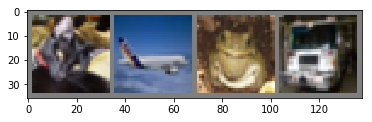

In [38]:
# Get random training images:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### define convolution neural network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [56]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### define loss function and optimizer

In [57]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train the network

In [58]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.262
[1,  4000] loss: 1.915
[1,  6000] loss: 1.662
[1,  8000] loss: 1.558
[1, 10000] loss: 1.496
[1, 12000] loss: 1.445
[2,  2000] loss: 1.366
[2,  4000] loss: 1.332
[2,  6000] loss: 1.304
[2,  8000] loss: 1.268
[2, 10000] loss: 1.261
[2, 12000] loss: 1.218
Finished Training


### test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar

GroundTruth:    cat  ship  ship plane


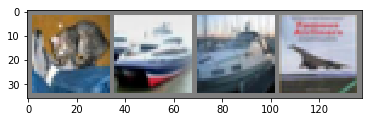

In [62]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Now see what the neural network thinks these examples above are:

In [63]:
outputs = net(Variable(images))

The outputs are energies for the 10 classes. Higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [64]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   frog   car   car  ship


Let's look at how the network performs on the whole dataset.

In [65]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


That looks waaay better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [66]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 76 %
Accuracy of  bird : 38 %
Accuracy of   cat : 49 %
Accuracy of  deer : 50 %
Accuracy of   dog : 36 %
Accuracy of  frog : 74 %
Accuracy of horse : 58 %
Accuracy of  ship : 72 %
Accuracy of truck : 67 %
